After we have run [income_gdp_pop_sc_dynamics_employment_correlation_matrices](https://www.dropbox.com/s/1s0zkqpf6pdhe93/income_gdp_pop_sc_dynamics_employment_correlation_matrices.ipynb?dl=0), we know a few things about collinearities and correlations of the features with the target variables.  We are going to follow the PCA->RFR route to identify where we can have good predictive models.  RFR will not tell us how these variable are correlated, but for that, we will use more sophisticated modeling techniques.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import seaborn as sns

%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()


gdpFile = helpers.mFiles["gdp"]
piFile = helpers.mFiles["pi"]
hhiFile = helpers.mFiles["hhi"]
populationFile = helpers.mFiles["pop"]
suicideFile = helpers.mFiles["sc"]
employFile = helpers.mFiles["emp"]

/Users/agilgur/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
compiledFile = MYDIR + "hhi_gdp_pop_sc_emp_ed_yr__preparing_for_modeling.csv"
rawData = pd.read_csv(compiledFile)
myData = rawData.loc[rawData["year"] >= 2014.0]
myData.head()

,county_state,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,EMPLOYED,ESTIMATESBASE,GDP,GDP_LOG,...,high_school_diploma,lt_high_school_diploma,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars,pct__bachelors_degree_plus,pct__high_school_diploma,pct__lt_high_school_diploma,pct__some_college_or_assoc_degree,some_college_or_assoc_degree
14,"Abbeville, South Carolina",2014.0,242.0,NaN,261.0,-76.0,9756.0,NaN,NaN,NaN,...,5939.0,3402.0,45773.0,1.292694,35409.0,15.9,34.6,19.8,29.6,5077.0
15,"Abbeville, South Carolina",2015.0,247.0,NaN,317.0,80.0,9650.0,NaN,502241.0,5.700912,...,5939.0,3402.0,44996.0,1.293026,34799.0,15.9,34.6,19.8,29.6,5077.0
16,"Abbeville, South Carolina",2016.0,227.0,NaN,311.0,-46.0,9734.0,NaN,518042.0,5.714365,...,5939.0,3402.0,45543.0,1.314296,34652.0,15.9,34.6,19.8,29.6,5077.0
17,"Abbeville, South Carolina",2017.0,217.0,NaN,311.0,13.0,9514.0,NaN,524320.0,5.719596,...,5939.0,3402.0,47480.0,1.346798,35254.0,15.9,34.6,19.8,29.6,5077.0
18,"Abbeville, South Carolina",2018.0,237.0,NaN,260.0,54.0,9574.0,NaN,532044.0,5.725948,...,5939.0,3402.0,51486.0,1.403462,36685.0,15.9,34.6,19.8,29.6,5077.0


We shall first apply the process to NETMIG as the dependent variable

In [3]:
myPCAdata = myData[[cc for cc in myData.columns if "DOMESTICMIG" not in cc and "INTERNATIONALMIG" not in cc]].copy()
myPCAdata.drop("county_state", 1, inplace=True)
myPCAdata.drop("CENSUSPOP", 1, inplace=True)
myPCAdata.drop("POP_CDC", 1, inplace=True)
myPCAdata.drop("ESTIMATESBASE", 1, inplace=True)
myPCAdata.drop("NPOPCHG_", 1, inplace=True)
myPCAdata.drop("RNETMIG", 1, inplace=True)
myPCAdata.drop("SC_R_DEATH", 1, inplace=True)
myPCAdata.drop("SCDEATHS", 1, inplace=True)
myPCAdata.interpolate(inplace=True)
myPCAdata.fillna(method="ffill")

cols = list(myPCAdata.columns)
for ii in range(len(cols)):
    print(f"""{ii}: {cols[ii]}""")
myPCAdata.head()

0: year
1: BIRTHS
2: DEATHS
3: EMPLOYED
4: GDP
5: GDP_LOG
6: LABOR_FORCE
7: NATURALINC
8: NETMIG
9: POPESTIMATE
10: RBIRTH
11: RDEATH
12: RNATURALINC
13: SCRATE
14: UNEMPLOYED
15: UNEMPLOYMENT_RATE_PCT
16: bachelors_degree_plus
17: high_school_diploma
18: lt_high_school_diploma
19: mean_income__dollars
20: mean_to_median_household_income_ratio
21: median_income__dollars
22: pct__bachelors_degree_plus
23: pct__high_school_diploma
24: pct__lt_high_school_diploma
25: pct__some_college_or_assoc_degree
26: some_college_or_assoc_degree


,year,BIRTHS,DEATHS,EMPLOYED,GDP,GDP_LOG,LABOR_FORCE,NATURALINC,NETMIG,POPESTIMATE,...,high_school_diploma,lt_high_school_diploma,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars,pct__bachelors_degree_plus,pct__high_school_diploma,pct__lt_high_school_diploma,pct__some_college_or_assoc_degree,some_college_or_assoc_degree
14,2014.0,242.0,261.0,9756.0,NaN,NaN,10573.0,-19.0,-82.0,24795.0,...,5939.0,3402.0,45773.0,1.292694,35409.0,15.9,34.6,19.8,29.6,5077.0
15,2015.0,247.0,317.0,9650.0,502241.0,5.700912,10365.0,-70.0,73.0,24796.0,...,5939.0,3402.0,44996.0,1.293026,34799.0,15.9,34.6,19.8,29.6,5077.0
16,2016.0,227.0,311.0,9734.0,518042.0,5.714365,10300.0,-84.0,-53.0,24657.0,...,5939.0,3402.0,45543.0,1.314296,34652.0,15.9,34.6,19.8,29.6,5077.0
17,2017.0,217.0,311.0,9514.0,524320.0,5.719596,9973.0,-94.0,6.0,24567.0,...,5939.0,3402.0,47480.0,1.346798,35254.0,15.9,34.6,19.8,29.6,5077.0
18,2018.0,237.0,260.0,9574.0,532044.0,5.725948,9974.0,-23.0,43.0,24587.0,...,5939.0,3402.0,51486.0,1.403462,36685.0,15.9,34.6,19.8,29.6,5077.0


In [4]:
myPCAdata.dropna(inplace=True)

In [5]:
X = myPCAdata[[cc for cc in myPCAdata.columns if "NETMIG" not in cc]].copy()
X.head()

,year,BIRTHS,DEATHS,EMPLOYED,GDP,GDP_LOG,LABOR_FORCE,NATURALINC,POPESTIMATE,RBIRTH,...,high_school_diploma,lt_high_school_diploma,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars,pct__bachelors_degree_plus,pct__high_school_diploma,pct__lt_high_school_diploma,pct__some_college_or_assoc_degree,some_college_or_assoc_degree
78,2014.0,4986.0,2659.0,202897.0,15227573.0,7.036298,211675.0,2327.0,425471.0,11.851366,...,68554.0,14497.0,73523.0,1.317498,55805.0,37.8,23.0,4.9,34.4,102595.0
79,2015.0,5186.0,2855.0,209558.0,21444205.0,7.331310,217294.0,2331.0,432862.0,12.083888,...,68554.0,14497.0,74604.0,1.323799,56356.0,37.8,23.0,4.9,34.4,102595.0
80,2016.0,5074.0,2978.0,218120.0,22468149.0,7.351567,225548.0,2096.0,444486.0,11.566676,...,68554.0,14497.0,77433.0,1.332777,58099.0,37.8,23.0,4.9,34.4,102595.0
81,2017.0,4937.0,3053.0,227785.0,23670890.0,7.374215,234405.0,1884.0,456548.0,10.958521,...,68554.0,14497.0,80990.0,1.346445,60151.0,37.8,23.0,4.9,34.4,102595.0
82,2018.0,4946.0,3129.0,238575.0,24825864.0,7.394904,244766.0,1817.0,468764.0,10.690448,...,68554.0,14497.0,84735.0,1.342082,63137.0,37.8,23.0,4.9,34.4,102595.0


Before applying PCA, we should center and scale the data, but first split into the training and testing data sets.  The runPCA(...) method in mobilityMLhelpers takes care of that


------------Running RFR with 25 estimators ------------
RSq =  0.8087


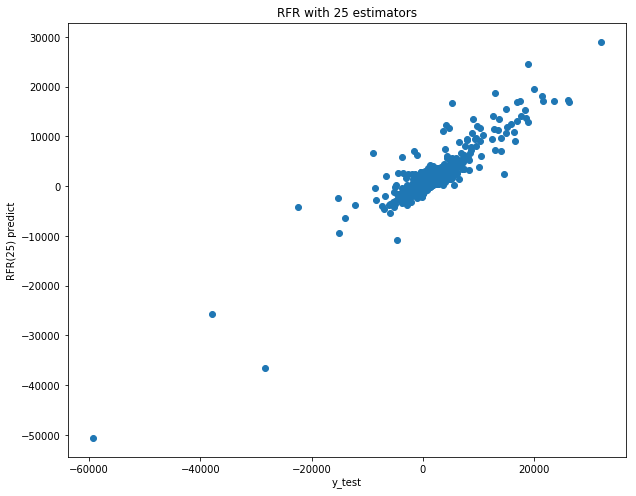

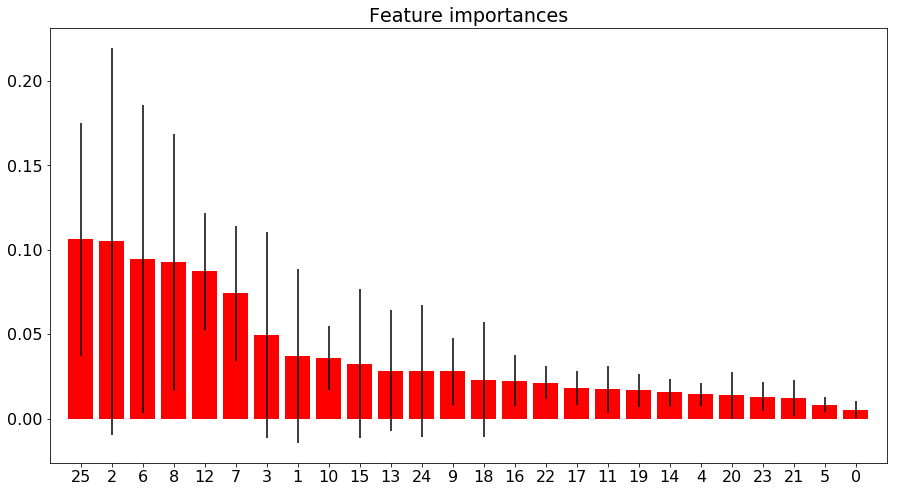

------------Running RFR with 50 estimators ------------
RSq =  0.7946


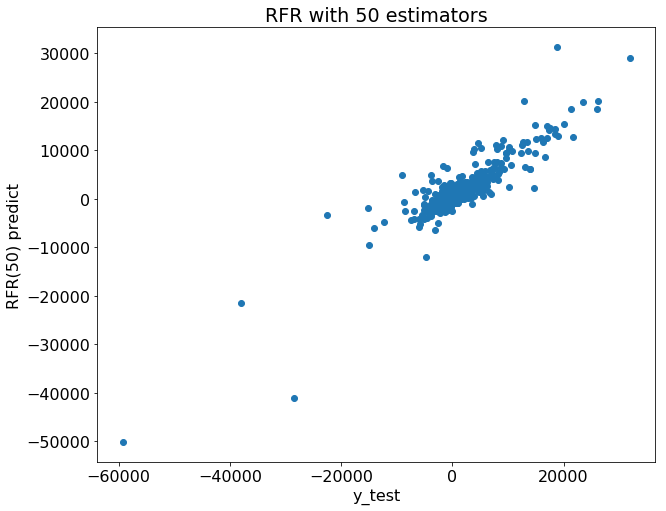

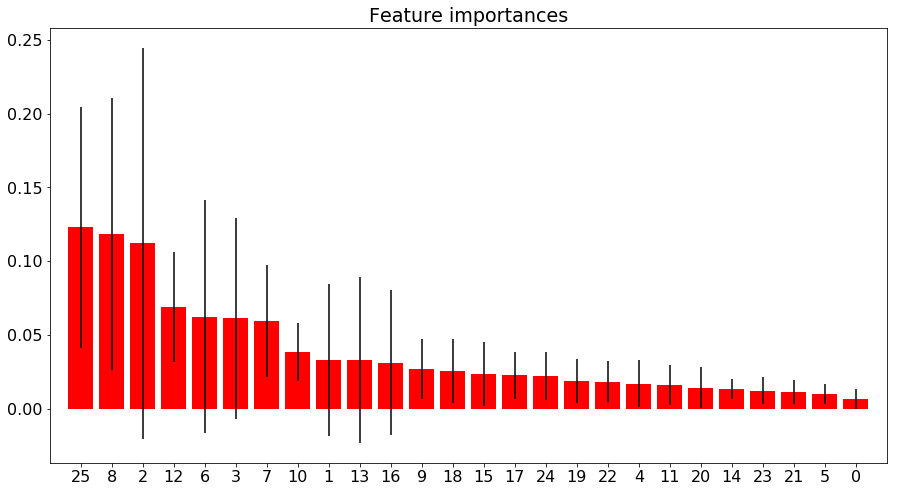

------------Running RFR with 75 estimators ------------
RSq =  0.8116


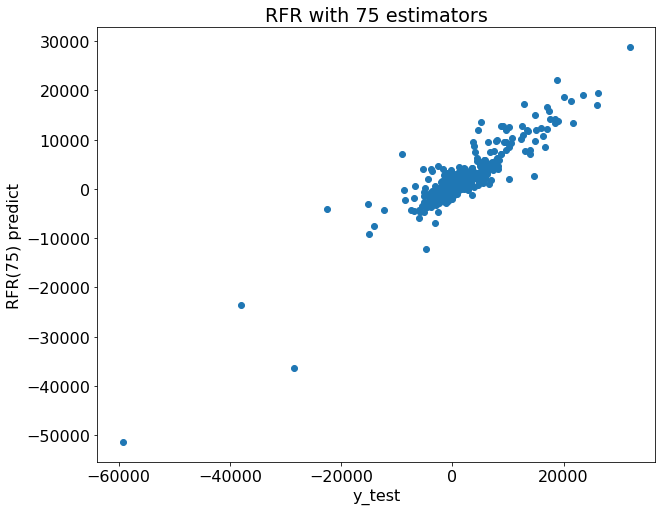

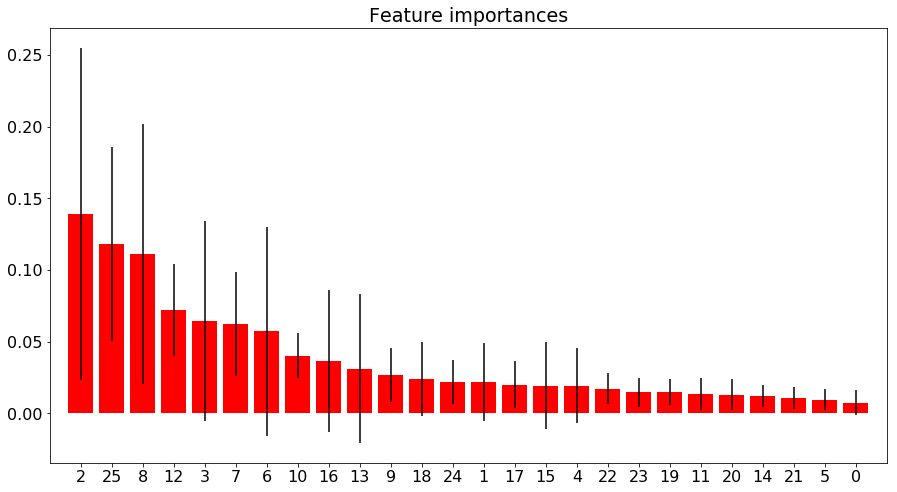

------------Running RFR with 100 estimators ------------
RSq =  0.8100


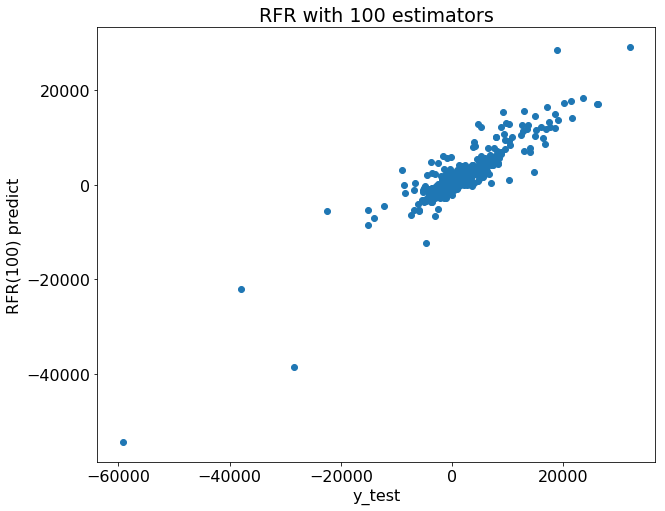

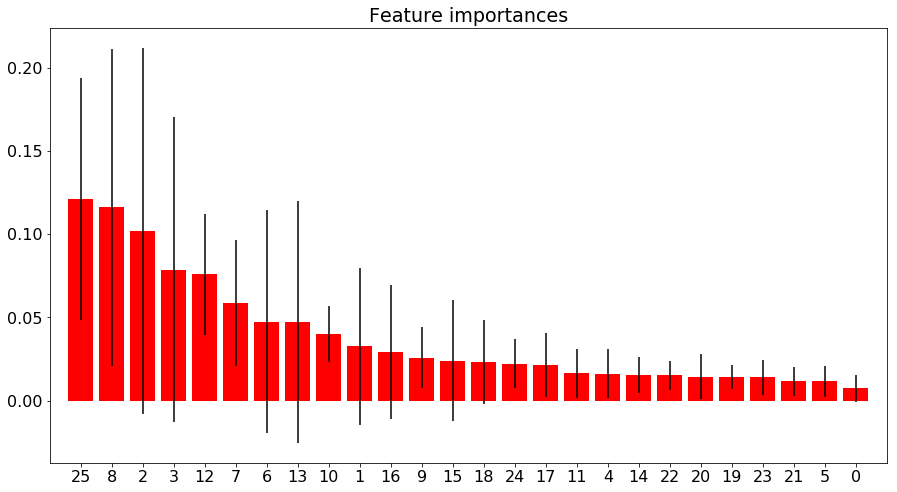

In [6]:
"""Random Forest Regression on Original Dimensions:"""
%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()
X_train, X_test, y_train, y_test = mlHelpers.splitDataIntoTrainTest(myPCAdata)

rsqHT = {} # Dict[int, float64]
rfrHT = {} # Dict[int, object]

print()
for nn in (25, 50, 75, 100):
    print(f"""------------Running RFR with {nn} estimators ------------""" )
    rsq, rfr = mlHelpers.fitRFR(nn, X_train, y_train, X_test, y_test)
    rsqHT[nn] = rsq
    rfrHT[nn] = rfr
    
    mlHelpers.plot_importances(rfr, X_test, y_test)


------------Running PCA estimators ------------
------------PCA Explained Variance------------
[1.20887513e+01 3.77746090e+00 2.06078498e+00 1.38233450e+00
 1.34335334e+00 1.06953840e+00 8.76174660e-01 6.61553093e-01
 6.06551321e-01 5.12348172e-01 4.06230613e-01 3.82739015e-01
 2.62025053e-01 1.81694023e-01 1.59011769e-01 9.23866020e-02
 6.09314188e-02 2.89741191e-02 2.53713672e-02 1.68456417e-02
 4.39990592e-03 2.15031380e-03 1.65912146e-05 5.86426750e-21
 6.95512177e-32 6.95512170e-32]
------------PCA Explained Variance Ratio------------
[4.64922879e-01 1.45277866e-01 7.92560008e-02 5.31633843e-02
 5.16642029e-02 4.11335180e-02 3.36969166e-02 2.54427575e-02
 2.33274371e-02 1.97044658e-02 1.56232766e-02 1.47198101e-02
 1.00772560e-02 6.98779435e-03 6.11545456e-03 3.55310849e-03
 2.34336946e-03 1.11431946e-03 9.75760750e-04 6.47868750e-04
 1.69216561e-04 8.26992015e-05 6.38083705e-07 2.25534635e-22
 2.67487944e-33 2.67487941e-33]
------------Components with Explained Variance Ratio > 0

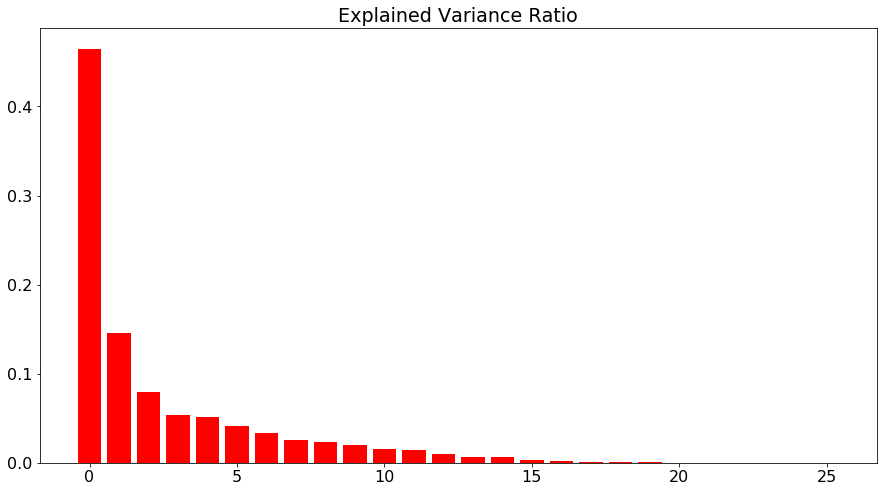

In [15]:
EXPL_VAR = 0.00

%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()

print(f"""------------Running PCA estimators ------------""" )
pca, X_train, X_test, y_train, y_test = \
    mlHelpers.runPCA(EXPL_VAR, myPCAdata, verbose=True)

mlHelpers.plot_explained_variance_pca(pca)

In [10]:
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))

cols = X_train_pca.columns
X_train_pca.columns = ["pc_" + str(cc) for cc in cols]
X_test_pca.columns = ["pc_" + str(cc) for cc in cols]
X_train_pca.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_16,pc_17,pc_18,pc_19,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25
0,0.352146,-0.362599,2.333201,0.223817,1.372375,0.876285,1.058442,0.547807,0.226942,1.983767,...,0.010747,-0.017138,0.040064,-0.016376,-0.079974,-0.014134,0.000499,1.404347e-11,6.555106e-16,4.452615e-16
1,-1.065628,0.949932,-0.185262,-0.186314,0.222029,0.330104,-1.146887,0.383133,0.215046,1.226234,...,-0.075691,0.044710,0.036070,0.021399,-0.033873,0.006841,0.000017,4.260719e-13,3.696015e-14,-1.543126e-14
2,2.463212,-2.164412,0.600751,0.141088,-1.269205,0.331534,-0.596349,0.942261,-0.772305,-0.789338,...,-0.069484,0.223975,-0.185163,0.009665,0.010937,0.058920,-0.004003,3.835687e-12,3.729572e-15,1.815616e-14
3,-1.698014,2.188327,-0.123236,-0.281001,0.391820,-0.612835,-0.218782,1.014298,0.644633,0.406473,...,-0.053731,0.020649,-0.038359,0.021717,-0.055817,-0.004334,0.007490,1.083608e-10,1.243067e-14,1.647473e-14
4,-0.068836,-1.653661,6.152412,0.958980,1.290928,-0.652812,-0.883397,0.437386,-2.335416,-0.417943,...,0.305455,0.095664,-0.128537,-0.061182,-0.122255,0.009725,0.000811,8.565247e-11,3.153576e-16,4.489654e-16



------------Running RFR with 25 estimators ------------
RSq =  0.7452


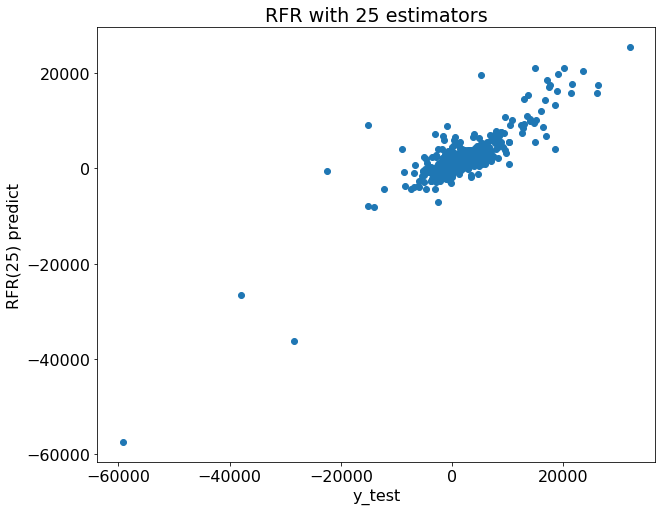

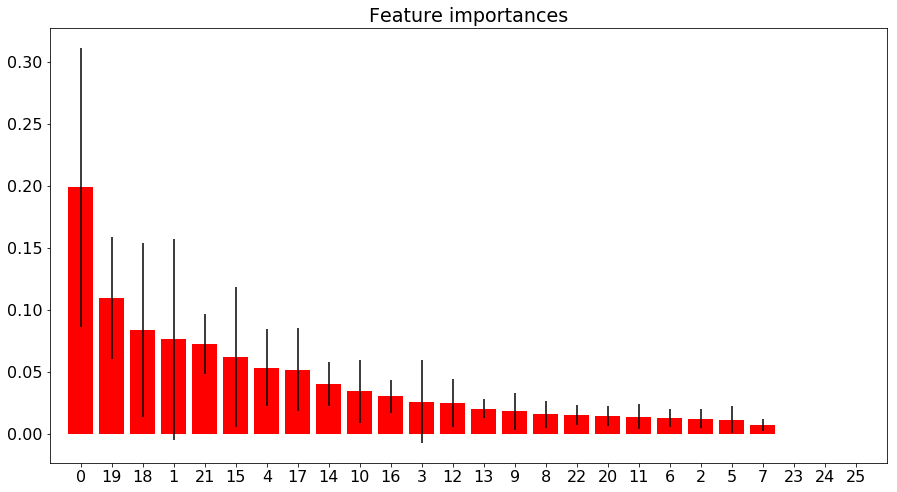

------------Running RFR with 50 estimators ------------
RSq =  0.7721


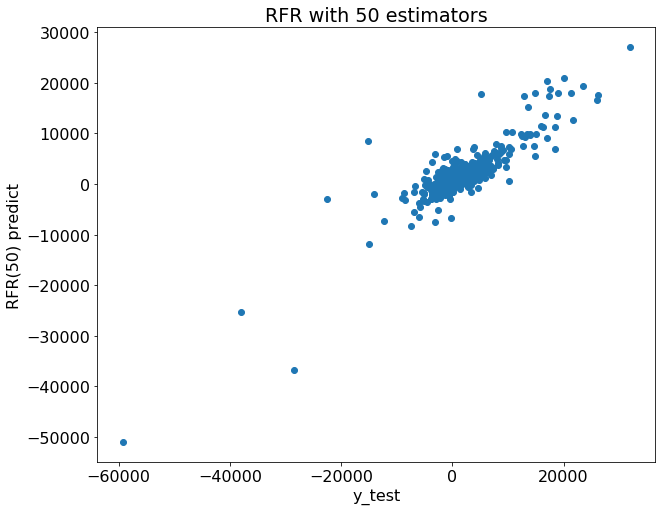

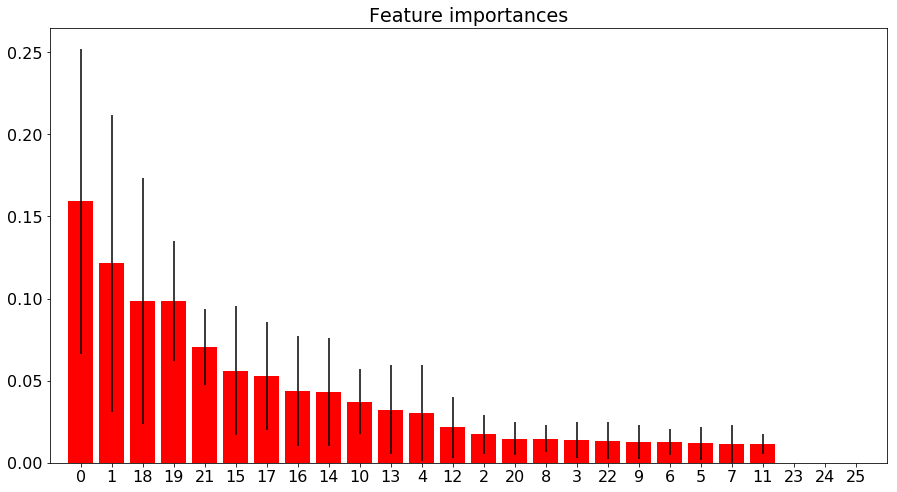

------------Running RFR with 75 estimators ------------
RSq =  0.7800


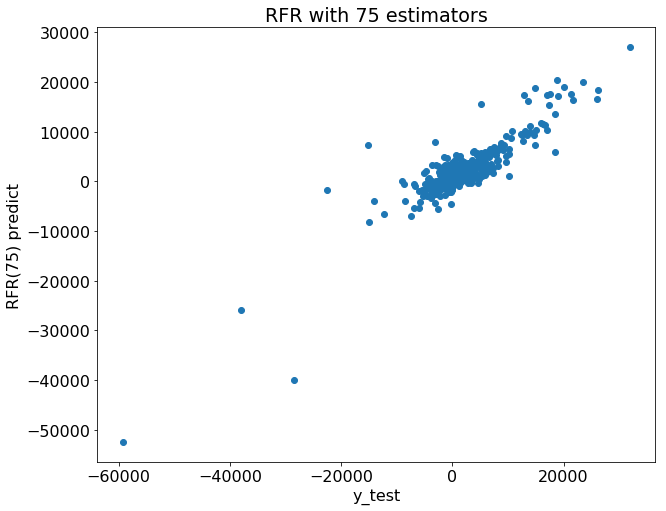

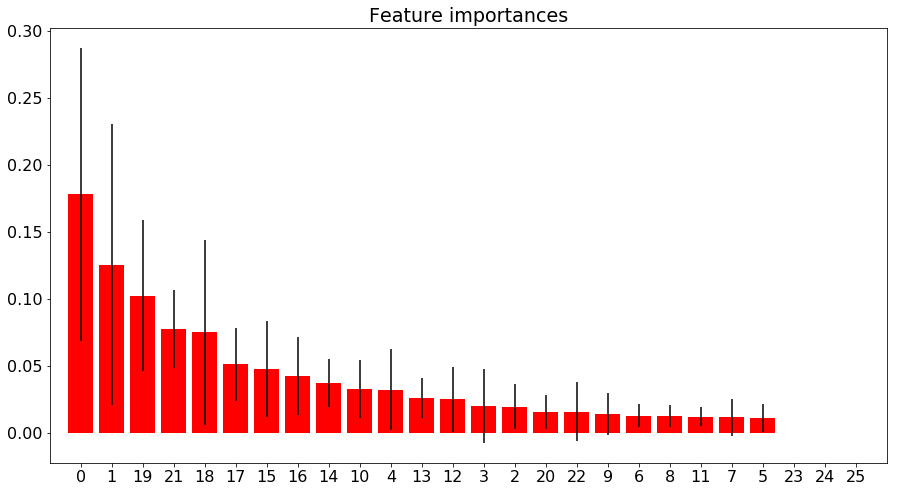

------------Running RFR with 100 estimators ------------
RSq =  0.7616


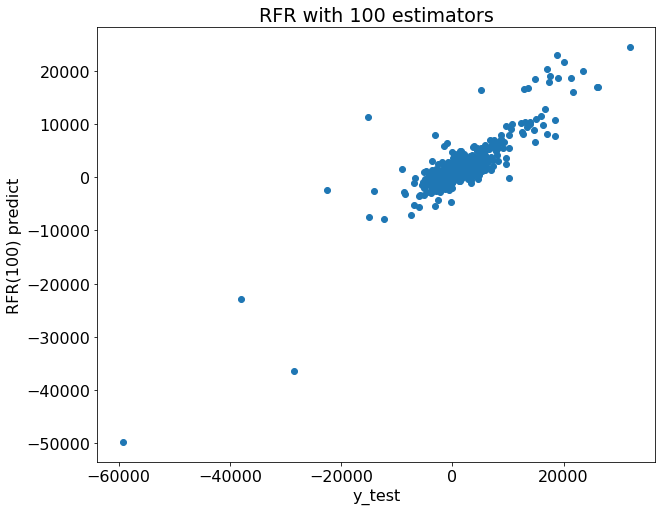

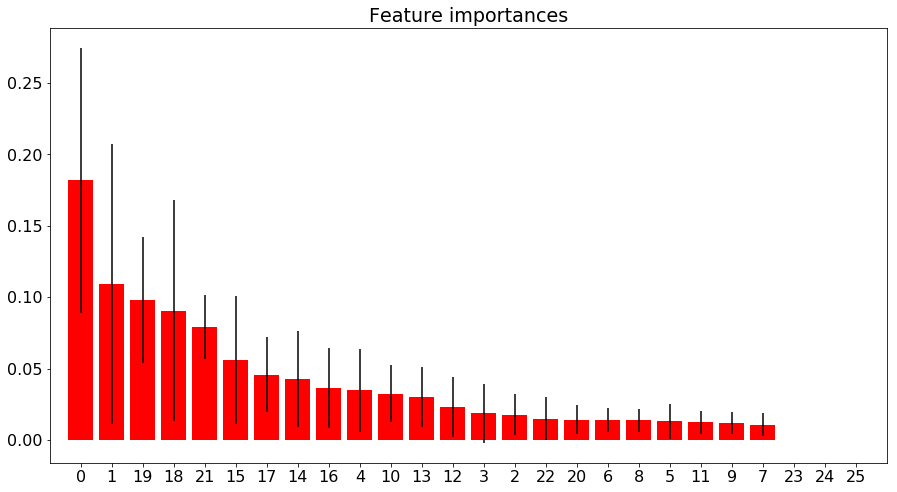

In [11]:
"""Random Forest Regression on Principal Components:"""
%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()

rsqHT = {} # Dict[int, float64]
rfrHT = {} # Dict[int, object]

print()
for nn in (25, 50, 75, 100):
    print(f"""------------Running RFR with {nn} estimators ------------""" )
    rsq, rfr = mlHelpers.fitRFR(nn, X_train_pca, y_train, X_test_pca, y_test)
    rsqHT[nn] = rsq
    rfrHT[nn] = rfr
    
        
    mlHelpers.plot_importances(rfr, X_test_pca, y_test)


In [12]:
nn = max(rsqHT, key=rsqHT.get)
rfr = rfrHT[nn]
rfr.feature_importances_

array([0.17806408, 0.12554841, 0.01976135, 0.0200839 , 0.03228854,
       0.01134354, 0.01305106, 0.01162706, 0.01286881, 0.01413736,
       0.03285463, 0.0120364 , 0.02499503, 0.02631441, 0.0372204 ,
       0.04756878, 0.0425911 , 0.05114967, 0.07496985, 0.10238115,
       0.01589484, 0.07751145, 0.01573817, 0.        , 0.        ,
       0.        ])

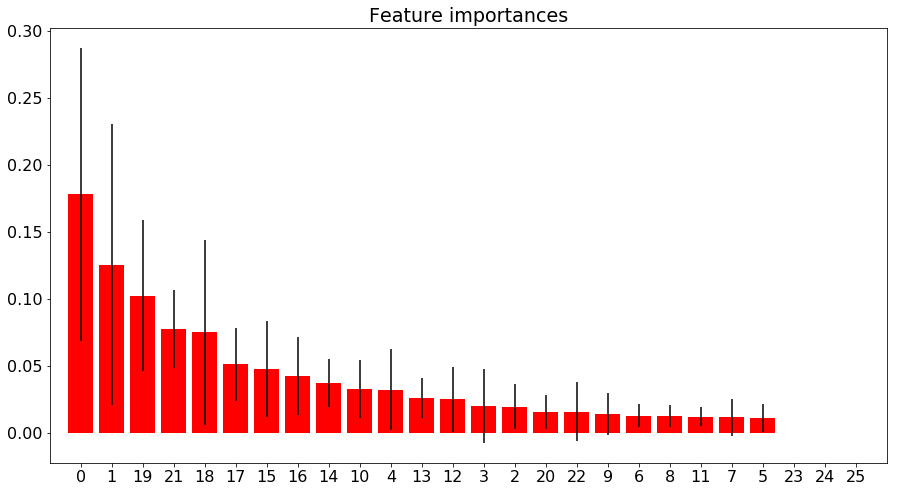

In [14]:
mlHelpers.plot_importances(rfr, X_test, y_test)

To reconstruct the original values, use https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com